In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from functools import reduce
from matplotlib import pyplot as plt
import seaborn as sns

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
# set of external covariates
covariates = pd.read_csv('datasets/covariates.csv') 

covariates['SchoolClo'] = covariates['SchoolClo'].apply(lambda x: datetime.strptime(x, '%d/%m/%Y').strftime('%Y-%m-%d'))
covariates['Lockdown'] = covariates['Lockdown'].apply(lambda x: datetime.strptime(x, '%d/%m/%Y').strftime('%Y-%m-%d'))
covariates['Manufactur'] = covariates['Manufactur'].apply(lambda x: datetime.strptime(x, '%d/%m/%Y').strftime('%Y-%m-%d'))

In [3]:
# load updated regional covid data from json
# Source: Dipartimento della Protezione Civile

url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-json/dpc-covid19-ita-regioni.json"
json_data = pd.read_json(url)
json_data.head()

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,...,note,ingressi_terapia_intensiva,note_test,note_casi,totale_positivi_test_molecolare,totale_positivi_test_antigenico_rapido,tamponi_test_molecolare,tamponi_test_antigenico_rapido,codice_nuts_1,codice_nuts_2
0,2020-02-24T18:00:00,ITA,13,Abruzzo,42.351222,13.398438,0,0,0,0,...,None,NaN,None,None,NaN,NaN,NaN,NaN,None,None
1,2020-02-24T18:00:00,ITA,17,Basilicata,40.639471,15.805148,0,0,0,0,...,None,NaN,None,None,NaN,NaN,NaN,NaN,None,None
2,2020-02-24T18:00:00,ITA,18,Calabria,38.905976,16.594402,0,0,0,0,...,None,NaN,None,None,NaN,NaN,NaN,NaN,None,None
3,2020-02-24T18:00:00,ITA,15,Campania,40.839566,14.250850,0,0,0,0,...,None,NaN,None,None,NaN,NaN,NaN,NaN,None,None
4,2020-02-24T18:00:00,ITA,8,Emilia-Romagna,44.494367,11.341721,10,2,12,6,...,None,NaN,None,None,NaN,NaN,NaN,NaN,None,None


In [4]:
n_json = len(json_data)
covid = {
    'date': json_data.data,
    'region': json_data.denominazione_regione,
    'icu': json_data.terapia_intensiva,
    'positives': json_data.totale_positivi,
    'deaths': json_data.deceduti,
    'cases': json_data.totale_casi,
    'swabs': json_data.tamponi,
}

# Remove time from dates
FMT = '%Y-%m-%dT%H:%M:%S' #datetime format
covid['date'] = covid['date'].apply(lambda x: datetime.strptime(x, FMT).strftime('%Y-%m-%d'))

In [5]:
datetoday = covid['date'].max()
print("Most recent date is", datetoday)

dates = covid['date'].unique()

Most recent date is 2021-01-22


In [6]:
# define time variable
x = np.arange(0, len(dates))
m = len(x)

# look at regions in covid data
regions = covid['region'].unique()
n_reg  = len(regions)

# create matrices with CUMULATIVE counts of deaths, cases and swabs
# and current counts for ICU and positives
covid['positives']

0           0
1           0
2           0
3           0
4          18
        ...  
7009    47289
7010     8202
7011     4880
7012      331
7013    49850
Name: totale_positivi, Length: 7014, dtype: int64

In [7]:
DEAcum = pd.DataFrame(0, index=regions, columns=dates, dtype='int')
CAScum = pd.DataFrame(0, index=regions, columns=dates, dtype='int')
SWABcum = pd.DataFrame(0, index=regions, columns=dates, dtype='int')
ICUt = pd.DataFrame(0, index=regions, columns=dates, dtype='int')
POSt = pd.DataFrame(0, index=regions, columns=dates, dtype='int')

for i in range(0, n_reg):
    deaths = covid['deaths'].loc[json_data['denominazione_regione'] == regions[i]]
    cases = covid['cases'].loc[json_data['denominazione_regione'] == regions[i]]
    swabs = covid['swabs'].loc[json_data['denominazione_regione'] == regions[i]]
    icut = covid['icu'].loc[json_data['denominazione_regione'] == regions[i]]
    post = covid['positives'].loc[json_data['denominazione_regione'] == regions[i]]
    
    DEAcum.loc[regions[i]] = deaths.values
    CAScum.loc[regions[i]] = cases.values
    SWABcum.loc[regions[i]] = swabs.values
    ICUt.loc[regions[i]] = icut.values
    POSt.loc[regions[i]] = post.values

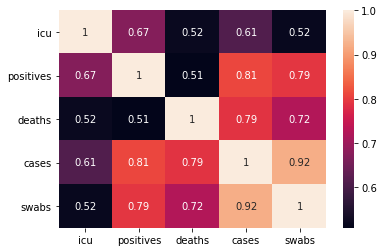

In [8]:
sns.heatmap(data=pd.DataFrame(covid)[['region','icu','positives', 'deaths','cases','swabs']].corr(), annot=True)
plt.show()

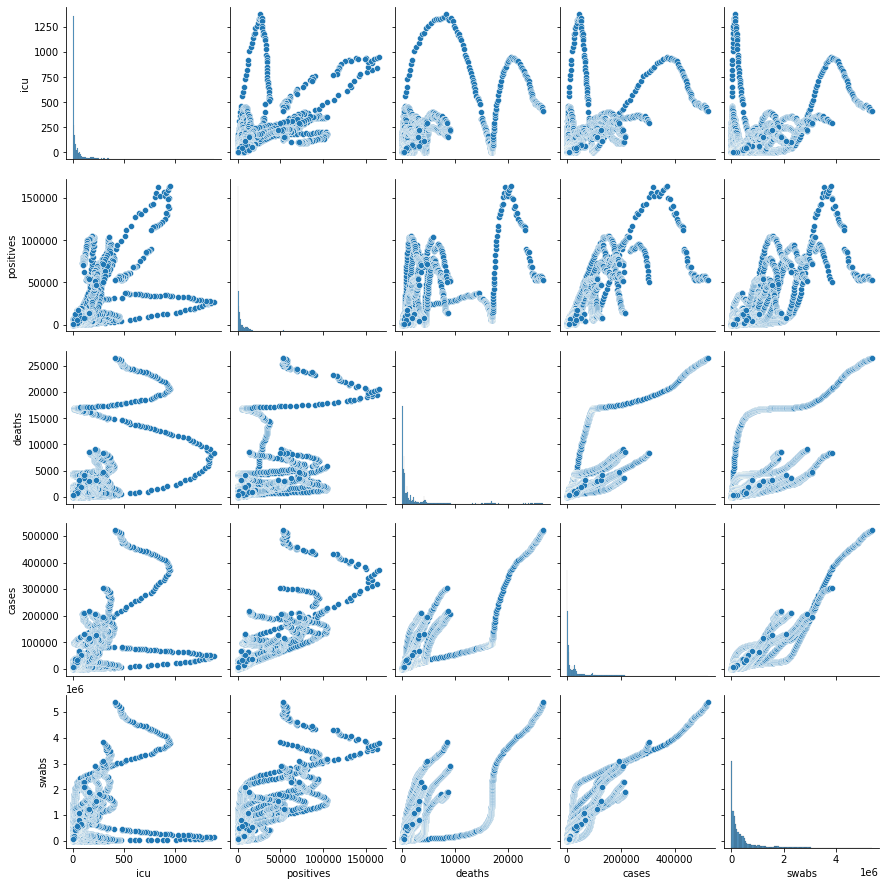

In [9]:
sns.pairplot(data=pd.DataFrame(covid)[['region','icu','positives', 'deaths','cases','swabs']])

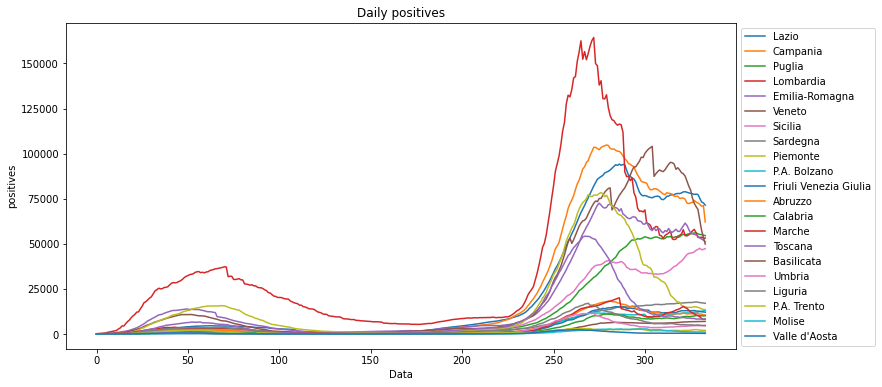

In [10]:
lastDate = POSt.iloc[:,-1:].columns[0]
region_sorted_by_deaths = POSt.iloc[:,-1:].sort_values(by=lastDate, ascending=False)
plt.figure(figsize=(12, 6)) 
plt.plot(x, POSt.sort_values(by=lastDate, ascending=False).T)
plt.xlabel('Data')
plt.ylabel('positives')
plt.title('Daily positives')
plt.legend(region_sorted_by_deaths.index, bbox_to_anchor=(1, 1), loc='upper left')
#plt.legend(handles=[p1, p2], title='title', bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)


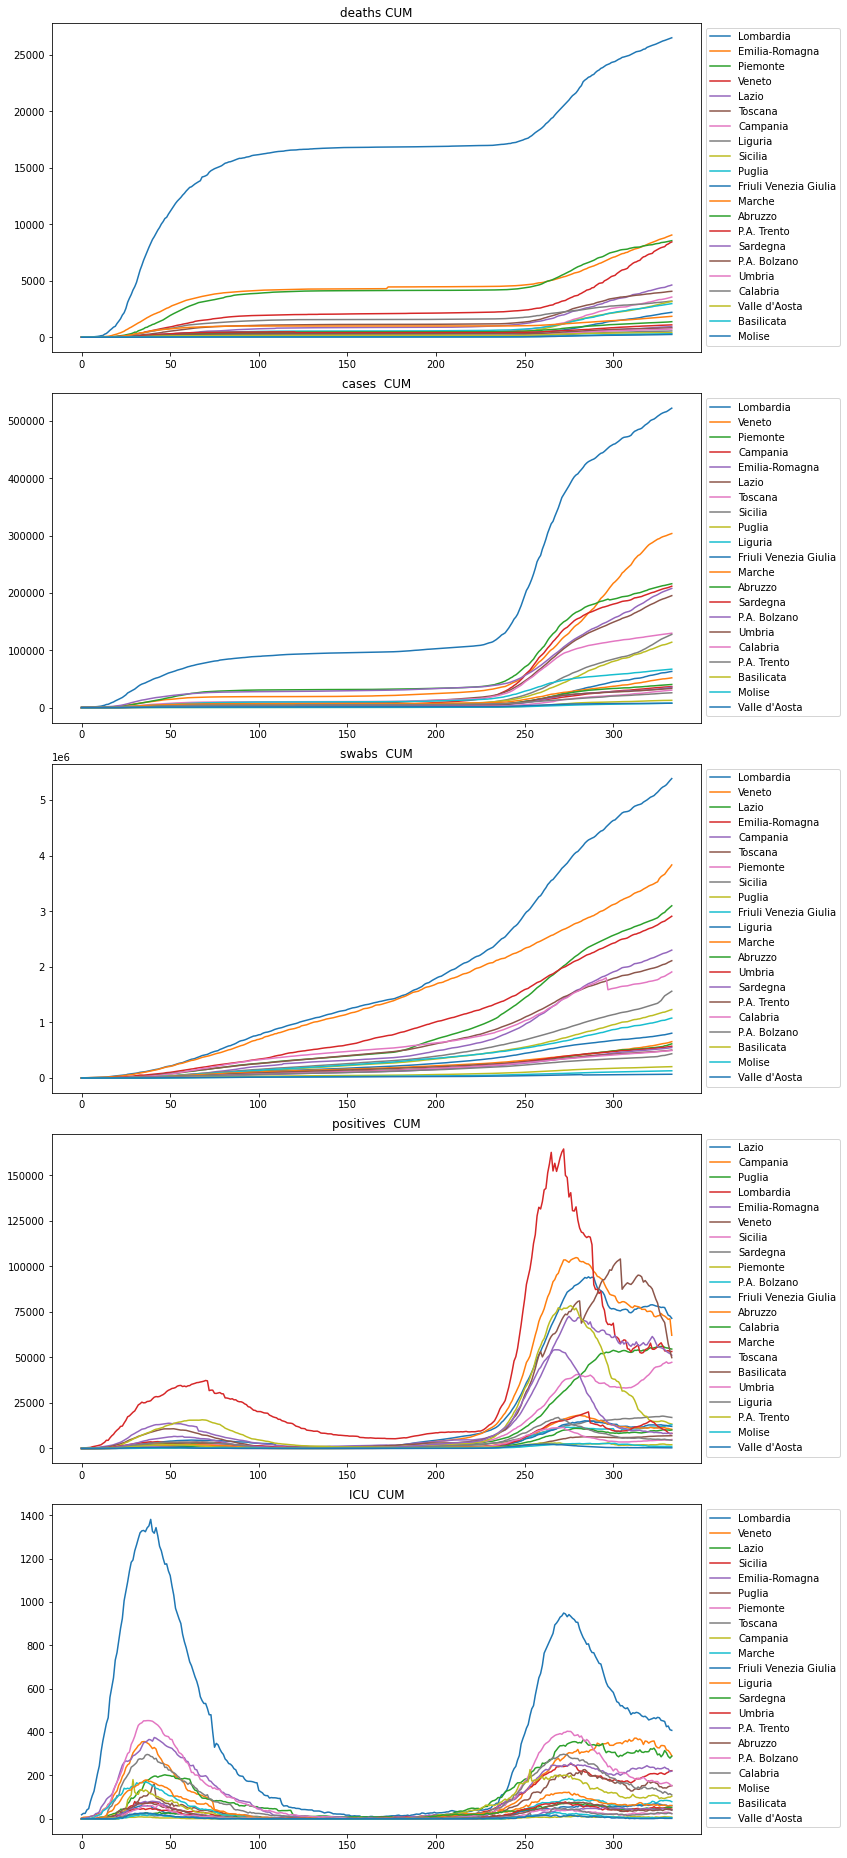

In [11]:
fig_row, fig_col = 5, 1
fig, axs = plt.subplots(fig_row, fig_col, figsize=(10, 26))
fig.tight_layout(pad=2.0)

axs[0].plot(x, DEAcum.sort_values(by=lastDate, ascending=False).T); axs[0].set_title('deaths CUM')
axs[1].plot(x, CAScum.sort_values(by=CAScum.iloc[:,-1:].columns[0], ascending=False).T); axs[1].set_title('cases  CUM')
axs[2].plot(x, SWABcum.sort_values(by=SWABcum.iloc[:,-1:].columns[0], ascending=False).T); axs[2].set_title('swabs  CUM')
axs[3].plot(x, POSt.sort_values(by=POSt.iloc[:,-1:].columns[0], ascending=False).T); axs[3].set_title('positives  CUM')
axs[4].plot(x, ICUt.sort_values(by=ICUt.iloc[:,-1:].columns[0], ascending=False).T); axs[4].set_title('ICU  CUM')

axs[0].legend(DEAcum.iloc[:,-1:].sort_values(by=lastDate, ascending=False).index, bbox_to_anchor=(1, 1), loc='upper left')
axs[1].legend(CAScum.iloc[:,-1:].sort_values(by=lastDate, ascending=False).index, bbox_to_anchor=(1, 1), loc='upper left')
axs[2].legend(SWABcum.iloc[:,-1:].sort_values(by=lastDate, ascending=False).index, bbox_to_anchor=(1, 1), loc='upper left')
axs[3].legend(POSt.iloc[:,-1:].sort_values(by=lastDate, ascending=False).index, bbox_to_anchor=(1, 1), loc='upper left')
axs[4].legend(ICUt.iloc[:,-1:].sort_values(by=lastDate, ascending=False).index, bbox_to_anchor=(1, 1), loc='upper left')

plt.show()

In [12]:
## wide format
regions_series = pd.Series(regions, index=regions, name='Territorio')

DEAcum_wide = pd.concat([regions_series, DEAcum], axis=1)
CAScum_wide = pd.concat([regions_series, CAScum], axis=1)
SWABcum_wide = pd.concat([regions_series, SWABcum], axis=1)
ICUt_wide = pd.concat([regions_series, ICUt], axis=1)
POSt_wide = pd.concat([regions_series, POSt], axis=1)

In [13]:
# long format
def pivot_longer(df, id_vars, value_vars, value_name, rename_col, sort_by):
    return pd.melt(df, id_vars=id_vars, value_vars=value_vars, value_name=value_name)\
                        .rename(columns=rename_col)\
                        .sort_values(by=sort_by)\
                        .reset_index(drop=True)

In [14]:
DEAcum_long = pivot_longer(DEAcum_wide, id_vars='Territorio', value_vars=dates, value_name='deathsCUM', rename_col={'variable': 'Date'}, sort_by=['Territorio', 'Date'])
CAScum_long = pivot_longer(CAScum_wide, id_vars='Territorio', value_vars=dates, value_name='casesCUM', rename_col={'variable': 'Date'}, sort_by=['Territorio', 'Date'])
SWABcum_long = pivot_longer(SWABcum_wide, id_vars='Territorio', value_vars=dates, value_name='swabsCUM', rename_col={'variable': 'Date'}, sort_by=['Territorio', 'Date'])
ICUt_long = pivot_longer(ICUt_wide, id_vars='Territorio', value_vars=dates, value_name='icu', rename_col={'variable': 'Date'}, sort_by=['Territorio', 'Date'])
POSt_long = pivot_longer(POSt_wide, id_vars='Territorio', value_vars=dates, value_name='positives', rename_col={'variable': 'Date'}, sort_by=['Territorio', 'Date'])

In [15]:
# we need daily number of counts, deaths and swabs
DEAt_long = DEAcum_long.copy()
CASt_long = CAScum_long.copy()
SWABt_long = SWABcum_long.copy()

DEAt_long['deaths'] = DEAcum_long['deathsCUM'] - DEAcum_long.groupby(['Territorio'])['deathsCUM'].shift(1)
CASt_long['cases'] = CAScum_long['casesCUM'] - CAScum_long.groupby(['Territorio'])['casesCUM'].shift(1)
SWABt_long['swabs'] = SWABcum_long['swabsCUM'] - SWABcum_long.groupby(['Territorio'])['swabsCUM'].shift(1)

In [16]:
# expand dataset
t = np.repeat(covariates['Territorio'], len(dates))
d = pd.Series(np.tile(dates, n_reg))

my_data = pd.DataFrame({'Territorio': t.values, 'Date': d.values })

# attach time-unvarying covariates
my_data2 = pd.merge(my_data, covariates, how="left", on=["Territorio"])

In [17]:
# create dummies for time-varing covariates
# (school closure, start lockdown)
my_data2['SchoolD'] = np.where(my_data2['SchoolClo'] <= my_data2['Date'], 1, 0)
my_data2['LockD'] = np.where(my_data2['Lockdown'] <= my_data2['Date'], 1, 0)
my_data2['ManufactD'] = np.where(my_data2['Manufactur'] <= my_data2['Date'], 1, 0)

In [18]:
# attach COVID cases, deaths, swabs and current ICU use
data_frames_to_merge = [my_data2, DEAt_long, CASt_long, SWABt_long, ICUt_long, POSt_long]
my_data3 = reduce(lambda left, right: pd.merge(left, right, on=["Territorio", "Date"]), data_frames_to_merge)
my_data3['deaths'] = np.where(my_data3['deaths'] < 0, 0, my_data3['deaths'])

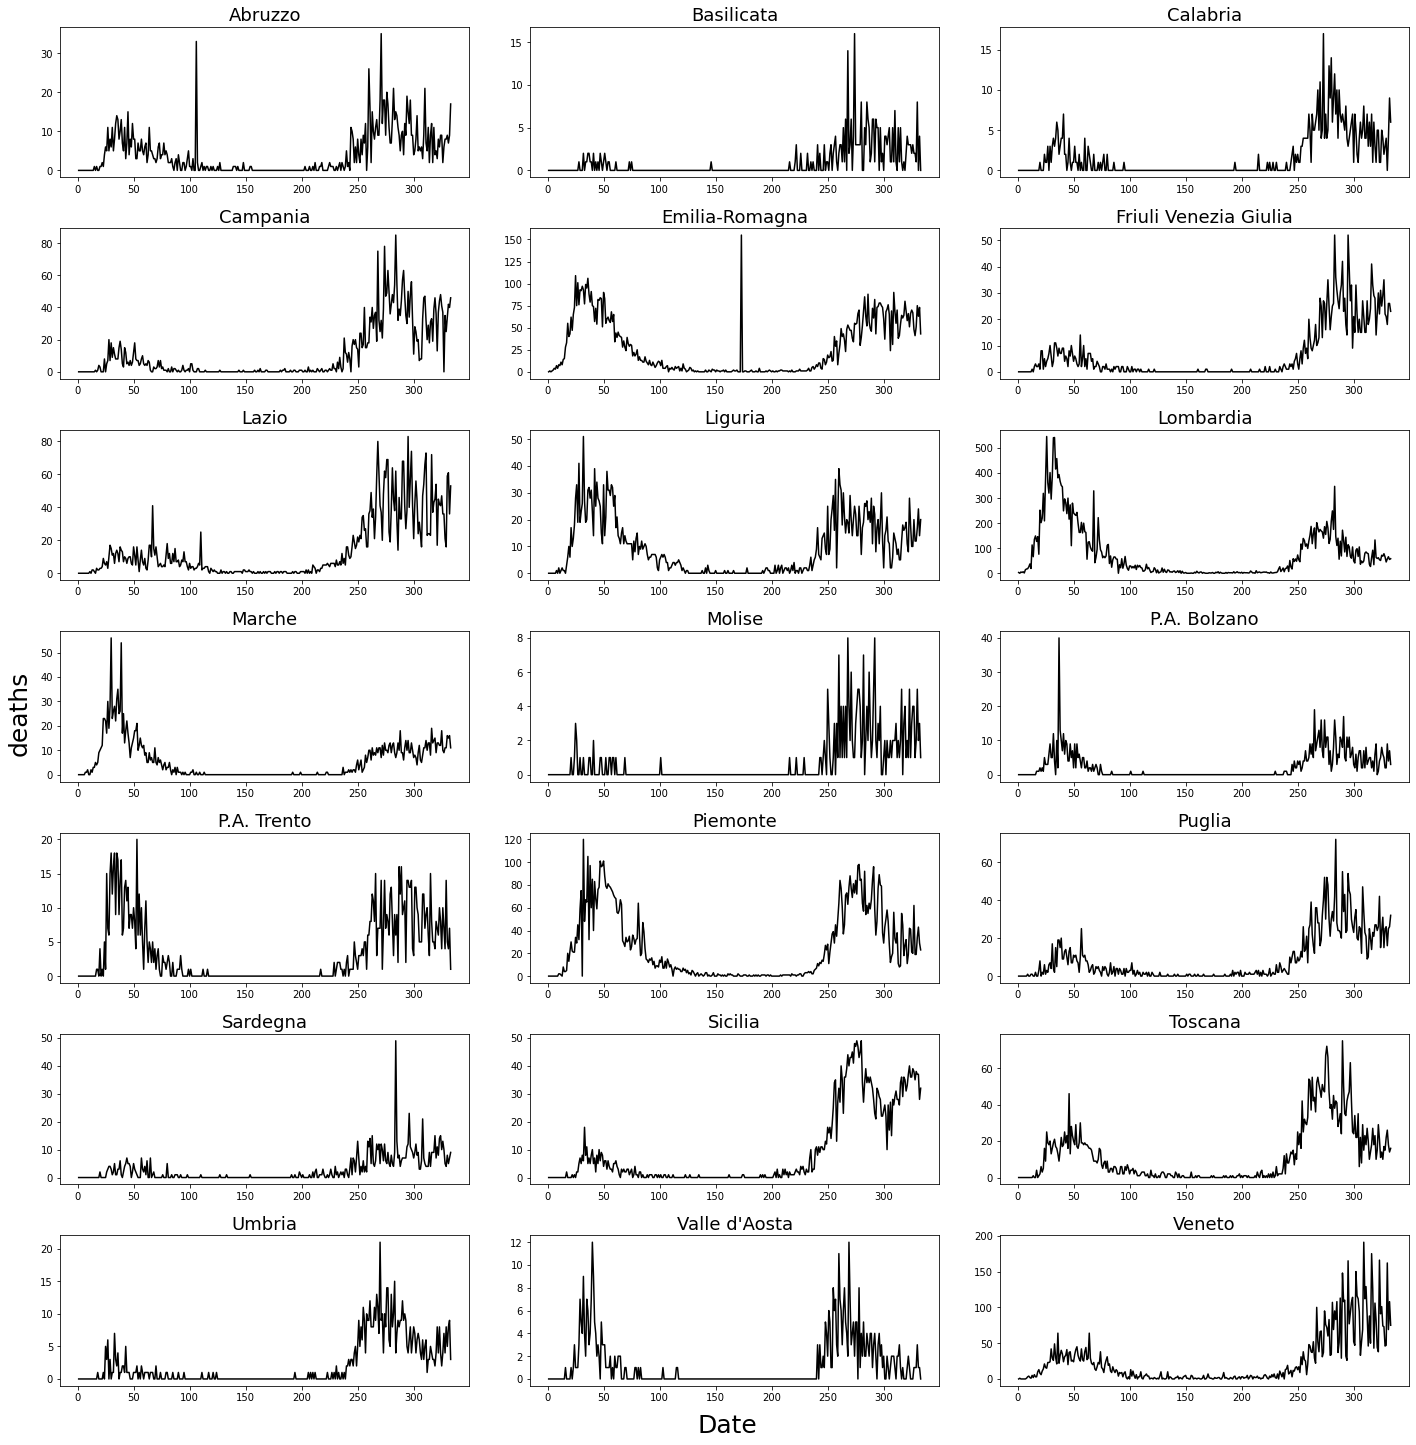

In [19]:
fig_row, fig_col = 7, 3
fig, axs = plt.subplots(fig_row, fig_col, figsize=(20, 20))
fig.tight_layout(pad=3.0)

r, c = -1, 0
for i in np.arange(0, n_reg):
    if i % fig_col == 0:
        r += 1
        c = 0
    else: 
        c += 1

    axs[r, c].plot(x, my_data3.deaths.loc[my_data3.Territorio == regions[i]], 'black')
    axs[r, c].set_title(regions[i],  fontsize=18)
    #axs[r, c].set_ylim(0, my_data3.deaths.max()+50)

fig.text(0.5, 0, 'Date', ha='center', fontsize=25)
fig.text(0, 0.5, 'deaths', va='center', rotation='vertical', fontsize=25)
plt.show()

In [20]:
# define start of epidemic as day when cumulative cases
# surpass total population / 10^6
covariates['thresh_epi'] = np.round(covariates['Pop2019'] * 1e-6, 0).astype('int')
covariates['thresh_epi'] = np.where(covariates['thresh_epi'] == 0, 1, covariates['thresh_epi'])

df_startepi = covariates[['Territorio', 'thresh_epi']]
# attach start epidemic and delay

In [21]:
my_data4 = pd.merge(my_data3, df_startepi, how="left", on=["Territorio"])

def mutate1(data):
    data['startEpiD'] = np.where(data.casesCUM >= data.thresh_epi, 1, 0)
    data['startEpi'] = data['Date'][data['startEpiD'] == 1].min()

    return data

my_data5 = my_data4.groupby(['Territorio']).apply(mutate1)
my_data5['startEpi'] = pd.to_datetime(my_data5['startEpi'])
my_data5['Date'] = pd.to_datetime(my_data5['Date'])
my_data5['DelayEpi'] = (my_data5['startEpi'] - my_data5['Date'].min()).dt.days

In [22]:
df_covid = my_data5.copy().dropna()
# transform variables
df_covid['swabsCUM'] = df_covid['swabsCUM'] / 1000
df_covid['time'] = np.tile(np.arange(1, len(dates)), n_reg)
df_covid['lGDPcap'] = np.round(np.log(df_covid.GDPcap), 2)

def mutate2(data):
    data['icupch'] = np.round((data.icu / data.ICU2019) * 100, 2)
    data['sqrtICU'] = np.round(np.sqrt(data.icupch), 2)
    data['sqrtPOS'] = np.round(np.sqrt(data.positives), 2)

    return data

df_covid = df_covid.groupby(['Territorio']).apply(mutate2)

In [23]:
# keep variables of interest and rename
columns_rename = {
    "Territorio": "region", 
    "Date": "date",
    "Pop2019": "population",
    "Pop65": "pop65",
    "Density2019": "density",
    "RSA": "nursehome",
    "swabsCUM": "swabs",
    "DelayEpi": "delayepi",
    "lGDPcap": "gdpcap",
    "sqrtICU": "icupch",
    "sqrtPOS": "positives",
    "House2019": "households"
}

var_of_interest = ['Territorio', 'Date', 'Pop2019', 'Pop65', 'Density2019', 'RSA','deaths', 'swabsCUM', 'DelayEpi', 'time', 'lGDPcap', 'sqrtICU','sqrtPOS', 'House2019']
df_covid = df_covid[var_of_interest].rename(columns=columns_rename)

In [24]:
df_covid.to_csv("datasets/dataCOVID_all.csv", index=False)